# Homology of Reachable Sets

Reachable set coordinator script: 
```bash
./scripts/federer_20240620.sh
```

Resulted in `../results/federer*/` folders. 

In [84]:
import glob
import json 
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import random
from tqdm import tqdm 

## Helper Functions

In [54]:
def load_results(results_folder):
    """
    Load the results from the specified folder.
    
    Args:
        results_folder (str): Path to the results folder.
        
    Returns:
        tuple: A tuple containing args, Y_to_U, R_t, and U_t.
    """
    with open(os.path.join(results_folder, "args.json"), "r") as f:
        args = json.load(f)
        
    with open(os.path.join(results_folder, "Y_to_U.json"), "r") as f:
        Y_to_U_ = json.load(f)
        # convert all keys to ints
        Y_to_U = {int(k): v for k, v in Y_to_U_.items()}
        
    with open(os.path.join(results_folder, "R_t.json"), "r") as f:
        R_t = json.load(f)
        
    with open(os.path.join(results_folder, "U_t.json"), "r") as f:
        U_t = json.load(f)

    # check if x_0_ids.json is in the results folder. if its there, 
    # load it. If not, just set x_0_ids to -1
    if os.path.exists(os.path.join(results_folder, "x_0_ids.json")):
        with open(os.path.join(results_folder, "x_0_ids.json"), "r") as f:
            x_0_ids = json.load(f)
    else:
        x_0_ids = -1

        
    return args, Y_to_U, R_t, U_t, x_0_ids

def check_data_consistency(args, Y_to_U, R_t, U_t, x_0_ids):
    """
    Check the consistency of the loaded data.
    
    Args:
        args (dict): The args dictionary.
        Y_to_U (dict): The Y_to_U dictionary.
        R_t (list): The R_t list.
        U_t (list): The U_t list.
    """
    assert len(R_t) == len(U_t), "R_t and U_t should have the same length."
    assert args["model"] is not None, "Model name should be specified in args."
    assert args["x_0"] is not None, "x_0 should be specified in args."
    if x_0_ids == -1: 
        print("x_0_ids not found. Skipping consistency check.")

In [87]:
def get_final_token_reps(Y_to_U, x_0_ids, model, tokenizer, max_debug=-1, max_eq_u = 100):
    """
    Get the final token representations for the given Y_to_U (dict[int, List[int]]).
    x_0_ids should be a tensor of shape [1, seq_len] on the model device.

    Returns: 
        final-token_reps: List[Dict[str, Any]] with dict_keys(['y', 'u_list',
        'y_str', 'u_str_list', 'final_token_rep']) where 'final_token_rep' 
        is a list of length num_layers with each element being a list of length hidden_size 
        corresponding to the final token reps at the given layer. 
    """
    final_token_reps = []
    cnt = 0 
    for y, u_list in tqdm(Y_to_U.items()):
        subcnt=0
        for u_spec in tqdm(u_list['all']):
            u_tensor = torch.tensor(u_spec).unsqueeze(0).to(model.device)
            input_ids = torch.cat([u_tensor, x_0_ids], dim=-1)
            attn_mask = input_ids != tokenizer.pad_token_id
            print("Attention mask: ", attn_mask)
            print("input_ids: ", input_ids)
            print("u_tensor: ", u_tensor)
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attn_mask, output_hidden_states=True)
                hidden_states = outputs.hidden_states # tuple of length num_layers. 
                # each outputs.hidden_states[i] is tuple of length batch_size
                # each outputs.hidden_states[i][0] is of shape [seq_len, hidden_size]
                # since we are passing a single input, we only have one element in the tuple 
                #   outputs.hidden_states[i]
                # we want to grab the final token representations for each layer

                final_token_rep = []
                for i in range(len(hidden_states)):
                    final_token_rep.append(hidden_states[i][0][-1, :].cpu().numpy().tolist())

            final_token_reps.append({
                "y": y,
                "u_list": u_spec,
                "y_str": tokenizer.decode(y),
                "u_str_list": [tokenizer.decode(u) for u in u_spec],
                "final_token_rep": final_token_rep, 
                "x_0_str": tokenizer.decode(x_0_ids[0]), 
                "x_0": x_0_ids[0].cpu().numpy().tolist()
            })
            cnt += 1
            if max_debug > 0 and cnt >= max_debug:
                break

            subcnt+=1 
            if subcnt > max_eq_u: 
                break
    return final_token_reps



## Constants

In [55]:
results_folder = "../results/federer_pool10_push1.0_randpoolfalse_2024-06-20-231034"
model_name = 'meta-llama/Meta-Llama-3-8b'

tokenizer = AutoTokenizer.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Function Calls

In [56]:
args, Y_to_U, R_t, U_t, x_0_ids = load_results(results_folder)
check_data_consistency(args, Y_to_U, R_t, U_t, x_0_ids)

In [57]:
# print x_0_ids 
print(x_0_ids)
print(args['x_0'])

[79525, 21780, 261, 374, 279, 220]
Roger Federer is the 


In [58]:
tokenizer.decode(16)

'1'

In [59]:
num_eq_u_per_y = {}

for y in R_t: 
    num_eq_u_per_y[y] = {'num_eq_u': len(Y_to_U[y]['all']), 'y_str': tokenizer.decode(y)}

# sort by key
num_eq_u_per_y = dict(sorted(num_eq_u_per_y.items()))
num_eq_u_per_y

{16: {'num_eq_u': 148407, 'y_str': '1'},
 17: {'num_eq_u': 204, 'y_str': '2'},
 18: {'num_eq_u': 1, 'y_str': '3'},
 19: {'num_eq_u': 4128931, 'y_str': '4'},
 20: {'num_eq_u': 40006, 'y_str': '5'},
 23: {'num_eq_u': 1, 'y_str': '8'},
 220: {'num_eq_u': 1, 'y_str': ' '},
 508: {'num_eq_u': 21756, 'y_str': '20'},
 605: {'num_eq_u': 1, 'y_str': '10'},
 679: {'num_eq_u': 908444, 'y_str': '201'},
 717: {'num_eq_u': 128, 'y_str': '12'},
 777: {'num_eq_u': 5, 'y_str': '19'},
 1041: {'num_eq_u': 1, 'y_str': '100'},
 1049: {'num_eq_u': 92, 'y_str': '200'},
 1135: {'num_eq_u': 1, 'y_str': '50'},
 1272: {'num_eq_u': 3, 'y_str': '40'},
 1691: {'num_eq_u': 5, 'y_str': '21'},
 2137: {'num_eq_u': 1, 'y_str': '39'},
 2366: {'num_eq_u': 11, 'y_str': '202'},
 3264: {'num_eq_u': 1, 'y_str': '98'}}

## Prior Probability Side Quest

Does the number of equivalent u correlate with the prior probability on y? 

In [60]:
model = AutoModelForCausalLM.from_pretrained(args['model'], device_map="auto")

Loading checkpoint shards: 100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


In [89]:
# set pad token if not set 
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = model.config.eos_token_id

In [61]:
x_0_ids = torch.tensor(x_0_ids).unsqueeze(0).to(model.device)
x_0_ids

tensor([[79525, 21780,   261,   374,   279,   220]], device='cuda:0')

In [62]:
logits_x_0 = model(x_0_ids)['logits']
print("logits_x_0 shape: ", logits_x_0.shape)

OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB. GPU 

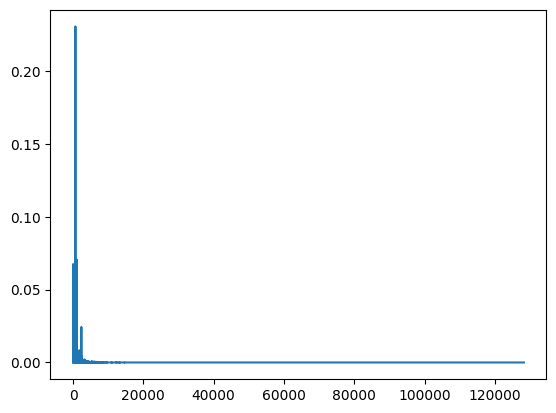

In [ ]:
# put logits_x_0 through softmax
y_logits = logits_x_0[0, -1, :]
y_probs = torch.nn.functional.softmax(y_logits, dim=0)
# line plot of y_probs
import matplotlib.pyplot as plt
plt.plot(y_probs.detach().cpu().numpy())


In [63]:
# associate each y with its probability
for y in num_eq_u_per_y.keys():
    num_eq_u_per_y[y]['prob'] = y_probs[y].detach().cpu().item()
    num_eq_u_per_y

In [67]:
num_eq_u_per_y

# remove element with minimal prob 
# num_eq_u_per_y.pop(min(num_eq_u_per_y, key=lambda x: num_eq_u_per_y[x]['prob']))


{'num_eq_u': 1, 'y_str': ' ', 'prob': 3.4507107216086297e-07}

Text(0.5, 1.0, 'Number of equivalent U vs. Probability')

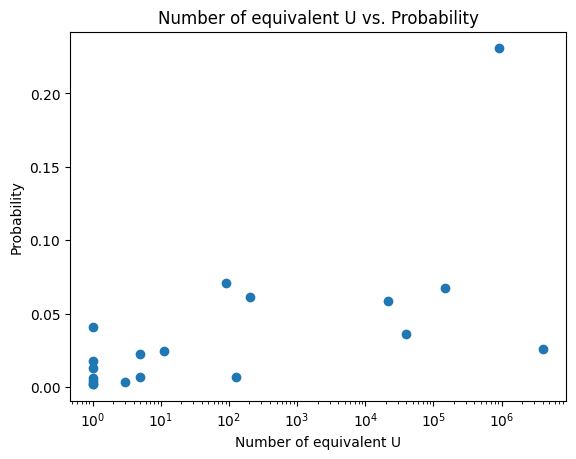

In [68]:
# scatter plot of prob vs. num_eq_u
plt.scatter([v['num_eq_u'] for v in num_eq_u_per_y.values()], [v['prob'] for v in num_eq_u_per_y.values()])
plt.xlabel('Number of equivalent U')
# log x axis 
plt.xscale('log')
plt.ylabel('Probability')
plt.title('Number of equivalent U vs. Probability')

# compute r^2 and put on plot
# make plot Nature paper-ready 
# save plot to results folder

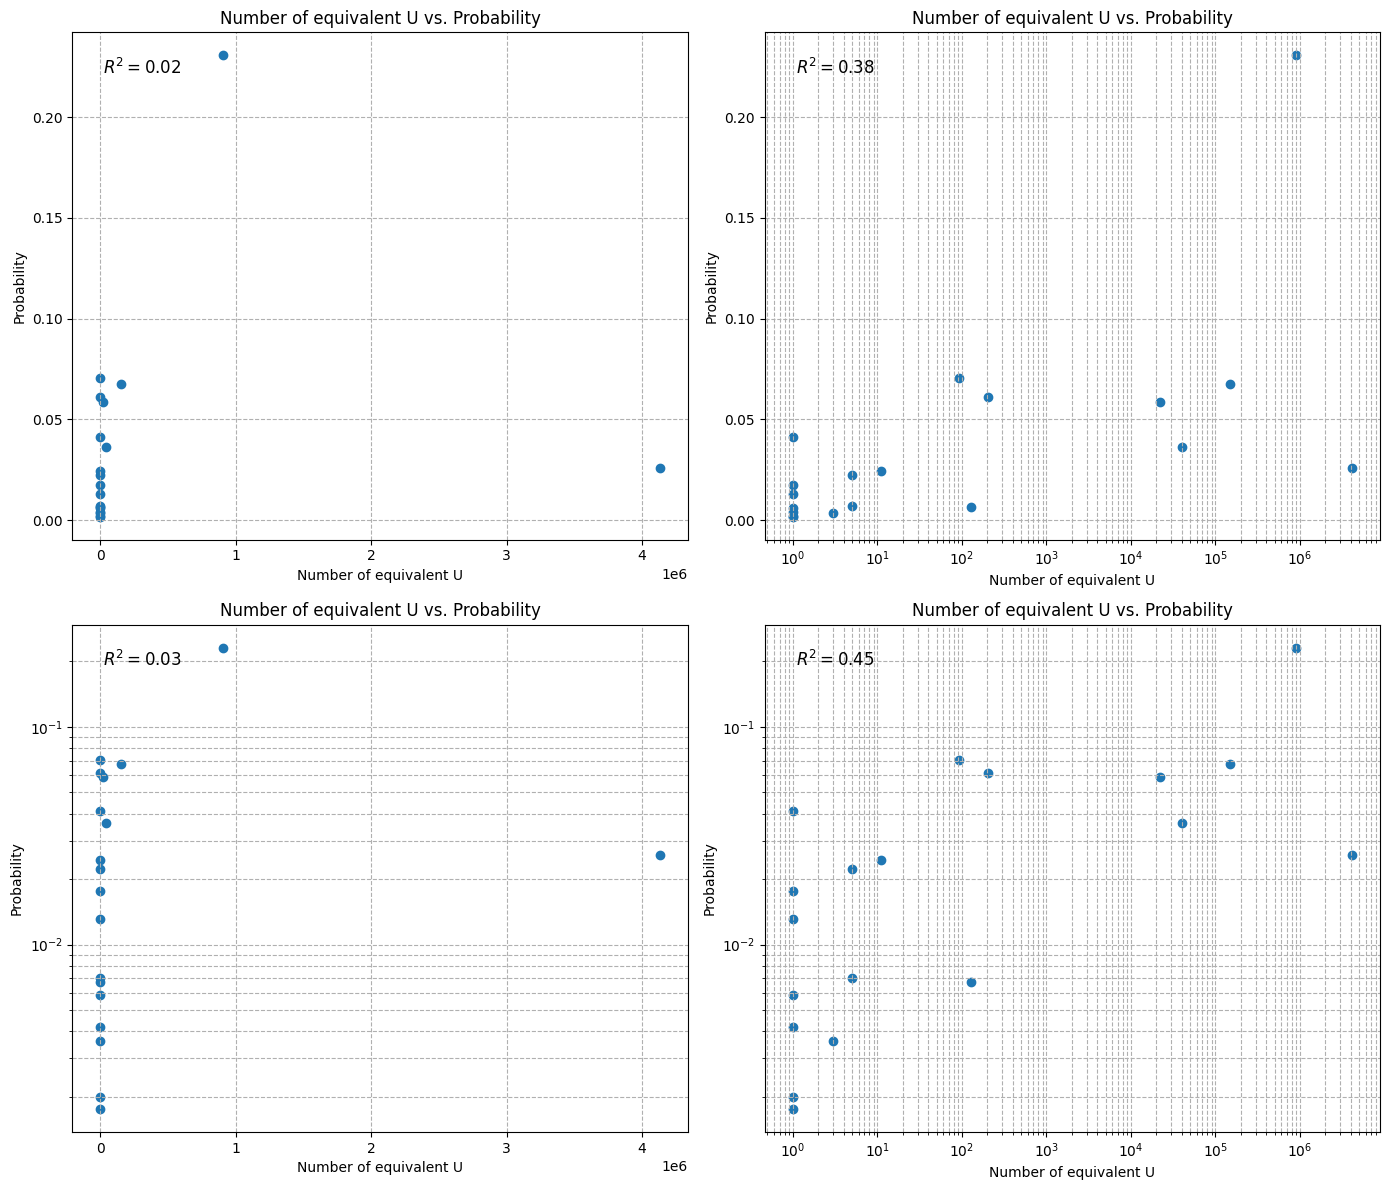


1. Top left: Regular x-axis and regular y-axis
2. Top right: Logarithmic x-axis and regular y-axis
3. Bottom left: Regular x-axis and logarithmic y-axis
4. Bottom right: Logarithmic x-axis and logarithmic y-axis



In [69]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Extracting data
num_eq_u = [v['num_eq_u'] for v in num_eq_u_per_y.values()]
prob = [v['prob'] for v in num_eq_u_per_y.values()]

# Define the results folder and figure name
results_folder = 'results'
fig_name = 'num_eq_u_vs_prob.png'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Function to create scatter plots and compute R^2
def create_scatter_plot(x, y, xlabel, ylabel, xscale, yscale, ax):
    ax.scatter(x, y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.grid(True, which="both", ls="--")
    
    # Fit linear model
    if xscale == 'log':
        X = np.log(np.array(x)).reshape(-1, 1)
    else:
        X = np.array(x).reshape(-1, 1)
        
    if yscale == 'log':
        y = np.log(np.array(y))
    else:
        y = np.array(y)
    
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    # Compute R^2
    r2 = r2_score(y, y_pred)
    ax.text(0.05, 0.95, f'$R^2 = {r2:.2f}$', transform=ax.transAxes, fontsize=12, verticalalignment='top')
    ax.set_title(f'{xlabel} vs. {ylabel}')
    return ax

# Creating the plots
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Regular x and y
create_scatter_plot(num_eq_u, prob, 'Number of equivalent U', 'Probability', 'linear', 'linear', axs[0, 0])

# Log x and regular y
create_scatter_plot(num_eq_u, prob, 'Number of equivalent U', 'Probability', 'log', 'linear', axs[0, 1])

# Regular x and log y
create_scatter_plot(num_eq_u, prob, 'Number of equivalent U', 'Probability', 'linear', 'log', axs[1, 0])

# Log x and log y
create_scatter_plot(num_eq_u, prob, 'Number of equivalent U', 'Probability', 'log', 'log', axs[1, 1])

plt.tight_layout()
plt.savefig(os.path.join(results_folder, fig_name), dpi=300)
plt.show()

# Annotations for each figure
annotations = """
1. Top left: Regular x-axis and regular y-axis
2. Top right: Logarithmic x-axis and regular y-axis
3. Bottom left: Regular x-axis and logarithmic y-axis
4. Bottom right: Logarithmic x-axis and logarithmic y-axis
"""

print(annotations)


## Output 1024 t-SNE Equivalent U Activations

We are interested in the token `y_str = '201'` which corresponds to `y_ids = 679`. 

We will sample 10,000 of them, find the activations on the last layer, then 
save the 16-dimensional tSNE. 

In [72]:
num_u_to_sample = 10000 
y_ids = 679
y_str = tokenizer.decode(y_ids)
tsne_output_dim = 16

In [76]:
all_u = Y_to_U[y_ids]['all']

# sample num_u_to_sample from this 
assert len(all_u) > num_u_to_sample
u_sampled = random.sample(all_u, num_u_to_sample)
print(f'Sampled U values: {len(u_sampled)}')
 

Sampled U values: 10000


In [79]:
Y_to_U[679].keys()

dict_keys(['first', 'all'])

In [80]:
Y_to_U_sampled = {y_ids: {
    'first': Y_to_U[y_ids]['first'], 
    'all': u_sampled
}}

In [86]:
x_0_ids

tensor([[79525, 21780,   261,   374,   279,   220]], device='cuda:0')

In [90]:
sampled_u_final_token_reps = get_final_token_reps(Y_to_U_sampled, x_0_ids, model, tokenizer, max_debug=-1, max_eq_u = 20000)

  0%|          | 0/1 [00:00<?, ?it/s]

Attention mask:  tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True]], device='cuda:0')
input_ids:  tensor([[ 11765, 100712, 119326, 112848, 120626,  78485, 124768, 112582, 102334,
         126755,  52938,  79525,  21780,    261,    374,    279,    220]],
       device='cuda:0')
u_tensor:  tensor([[ 11765, 100712, 119326, 112848, 120626,  78485, 124768, 112582, 102334,
         126755,  52938]], device='cuda:0')


  0%|          | 0/1 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB. GPU 